# Correlation among the Upwelling Indices

#### Correlation (between UI<sub>Ek</sub>, UI<sub>SST</sub> and UI<sub>SSH</sub>)
1. Annual mean/seasonal mean correlation (of the merdional mean)
    - annual mean correlation
    - seasonal summer mean correlation
2. Weekly correlation
    - check which delay gives the best correlation between the UIs
    - use this delay to plot the annual summer correlation at all lats (0.25° res, lowest matched to UI Ek)
    - UI<sub>Ek</sub> and UI<sub>SST</sub>, with UI<sub>Ek</sub> 1 week advanced
    - UI<sub>Ek</sub> and UI<sub>SSH</sub>, with UI<sub>Ek</sub> 4 weeks advanced
    - UI<sub>SST</sub> and UI<sub>SSH</sub>, as they are


## Import packages and data

In [1]:
## import packages
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.dates as dates
import matplotlib
import cartopy.crs as ccrs
import os
import my_functions
from scipy.stats import pearsonr
%matplotlib inline

In [2]:
## import data
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Data.nosync/')
MTSS = xr.open_dataset('MTSS_weekly.nc')
UI_SST = xr.open_dataset('UI_SST.nc')
SST = xr.open_dataset('CoRTAD_weekly.nc')
SSH = xr.open_dataset('SSH_weekly.nc') # SSH IBI
Angles = xr.open_dataset('Angles_coast.nc')
# mid-shelf coordinates
mid_shelf_lat = np.genfromtxt('CoRTAD/lat_midshelf_CoRTAD.dat')[:,1]
mid_shelf_lon = np.genfromtxt('CoRTAD/lon_midshelf_CoRTAD.dat')[:,1]

In [3]:
## set dir where I want to save my figures
os.chdir('/Users/marie-louisekorte/Documents/Uni Leipzig/Lisbon/Iberian_Coast_Upwelling/Figures/Round II/')

## Data Prep

In [4]:
## selct common period MTSS and SST
MTSS = MTSS.sel(time = slice('01/01/1982', '31/12/2022'))
SST = SST.sel(time = slice('01/01/1982', '31/12/2022'))

In [5]:
## calculate the UIs (and add mid_shelf mask)
# UI Ek
Ek = my_functions.calc_upwelling_index(MTSS, MTSS.lat, MTSS.lon, MTSS.metss.where(MTSS.lsm), MTSS.mntss.where(MTSS.lsm), 
                                       near_shore = True, angles = Angles.angle_phi)
Ek = my_functions.add_mid_shelf(Ek, mid_shelf_lat, mid_shelf_lon)

# UI SST and SSH
SST = my_functions.add_mid_shelf(SST, mid_shelf_lat, mid_shelf_lon)
SST['UI'] = SST.SST.where(SST.lon == -15.019103) - SST.SST.where(SST.mid_shelf).mean(dim = 'lon')
SST.UI.attrs.update({'Name' : 'SST upwelling index', 'Info' : 'SST at 15° - SST at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

SSH = my_functions.add_mid_shelf(SSH, mid_shelf_lat, mid_shelf_lon)
SSH['UI'] = SSH.zos.where(SSH.lon == -10.5) - SSH.zos.where(SSH.mid_shelf).mean(dim = 'lon')
SSH.UI.attrs.update({'Name' : 'SSH upwelling index', 'Info' : 'SSH at 10.5°W - SSH at mid-shelf', 'Sign' : 'positive inidcates upwelling'})

In [6]:
## meridional mean
Ek = my_functions.calc_meridional_mean(Ek, lon = -10.5)
SST = my_functions.calc_meridional_mean(SST, lon = -15.019103)
UI_SST = my_functions.calc_meridional_mean(UI_SST, lon = -15)
SSH = my_functions.calc_meridional_mean(SSH, lon = -10.5)

In [7]:
## summer subset
Ek_summer = my_functions.subset_summer(Ek)
SST_summer = my_functions.subset_summer(SST)
UI_SST_summer = my_functions.subset_summer(UI_SST)
SSH_summer = my_functions.subset_summer(SSH)

In [8]:
# create Ek_ns dataset with meridional mean and summer subset
Ek_ns = Ek
Ek_ns = Ek_ns.drop_vars(["UI", "UI_mean"])
Ek_ns['UI'] = Ek_ns.UI_ns 
UI_mean = Ek_ns.UI.mean(dim = ['lat', 'lon'])
Ek_ns['UI_mean'] = UI_mean
Ek_ns_summer = my_functions.subset_summer(Ek_ns)

## Functions

In [9]:
def plot_correlation(DS1, DS2, DS3, DS1_var = r'$UI_{Ek}$', DS2_var = r'$UI_{SST}$', DS3_var = r'$UI_{SSH}$', summer = False, save = False, save_fig_as = 'Cor'): #, DS1_col = 'dodgerblue', DS2_col = 'forestgreen', DS3_col = 'darkcyan'):

    if summer:
        summer = 'summer '
        loc1 = 2.3
        loc2 = 1.3
        loc3 = 0.3
    else:
        summer = ' '
        loc1 = 1.3
        loc2 = 0.65
        loc3 = 0
    
    # centered data
    x_summer = (DS1.UI_mean - DS1.UI_mean.mean())/DS1.UI_mean.std()
    y_summer = (DS2.UI_mean - DS2.UI_mean.mean())/DS2.UI_mean.std()
    z_summer = (DS3.UI_mean - DS3.UI_mean.mean())/DS3.UI_mean.std()
    
    fig, ([ax1, ax2],[ax3, ax4]) = plt.subplots(2, 2, figsize = (12, 6))
    
    ax1.plot(DS1.time, DS1.UI_mean, color = 'darkcyan', alpha = 0.8)
    ax1.plot(DS2.time, DS2.UI_mean, color = 'rebeccapurple', alpha = 0.8)
    ax1.plot(DS3.time, DS3.UI_mean, color = 'darkgreen', alpha = 0.8)

    # print correlation
    result = pearsonr(DS1.UI_mean, DS2.UI_mean)
    ax1.text(20500, loc1, f"{DS1_var} vs {DS2_var} \n  cor: {result[0]:.3f} \n  p-vlaue: {result[1]:.3f}")
    result = pearsonr(DS2.UI_mean.where(DS2.time == DS3.time, drop = True), DS3.UI_mean)
    ax1.text(20500, loc2, f"{DS2_var} vs {DS3_var} \n  cor: {result[0]:.3f} \n  p-vlaue: {result[1]:.3f}")
    result = pearsonr(DS3.UI_mean, DS1.UI_mean.where(DS2.time == DS3.time, drop = True))
    ax1.text(20500, loc3, f"{DS3_var} vs {DS1_var} \n  cor: {result[0]:.3f} \n  p-vlaue: {result[1]:.3f}")
    
    ax1.set_title(f'Annual {summer}mean')
    
    ax2.hist(DS1.UI_mean, color = 'darkcyan', alpha = 0.5, label = r'$UI_{Ek}$')
    ax2.hist(DS2.UI_mean, color = 'rebeccapurple', alpha = 0.5, label = r'$UI_{SST}$')
    ax2.hist(DS3.UI_mean, color = 'darkgreen', alpha = 0.5, label = r'$UI_{SSH}$')
    ax2.set_title(f'Annual {summer}mean distribution')
    ax2.legend()
    
    ax3.plot(DS1.time, x_summer, color = 'darkcyan', alpha = 0.6)
    ax3.plot(DS2.time, y_summer, color = 'rebeccapurple', alpha = 0.6)
    ax3.plot(DS3.time, z_summer, color = 'darkgreen', alpha = 0.6)
    # result = pearsonr(x_summer, y_summer) same as above
    # ax3.text(4300, 1.6, f"correlation: {result[0]:.3f} \np-vlaue: {result[1]:.3f}")
    ax3.set_title(f'Annual {summer}mean centered')
    
    ax4.hist(x_summer, color = 'darkcyan', alpha = 0.5)
    ax4.hist(y_summer, color = 'rebeccapurple', alpha = 0.5)
    ax4.hist(z_summer, color = 'darkgreen', alpha = 0.5)
    ax4.set_title(f'Annual {summer}mean distribution centered')
    fig.tight_layout()

    if save:
        fig.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches = 'tight')
# correlation here is a a bit lower than the annual mean
# still statistically significant

In [10]:
def plot_correlation_SST(DS1, DS2, DS3, DS1_var = r'$UI_{Ek}$', DS2_var = r'$UI_{SST}$', DS3_var = r'$UI_{Ek} ns$', summer = False, save = False, save_fig_as = 'Cor'): #, DS1_col = 'dodgerblue', DS2_col = 'forestgreen', DS3_col = 'darkcyan'):

    if summer:
        summer = 'summer '
        loc1 = 2.3
        loc2 = 1.3
        loc3 = 0.3
    else:
        summer = ' '
        loc1 = 1.3
        loc2 = 0.65
        loc3 = 0
    
    # centered data
    x_summer = (DS1.UI_mean - DS1.UI_mean.mean())/DS1.UI_mean.std()
    y_summer = (DS2.UI_mean - DS2.UI_mean.mean())/DS2.UI_mean.std()
    z_summer = (DS3.UI_mean - DS3.UI_mean.mean())/DS3.UI_mean.std()
    
    fig, ([ax1, ax2],[ax3, ax4]) = plt.subplots(2, 2, figsize = (12, 6))
    
    ax1.plot(DS1.time, DS1.UI_mean, color = 'darkcyan', alpha = 0.8)
    ax1.plot(DS2.time, DS2.UI_mean, color = 'rebeccapurple', alpha = 0.8)
    ax1.plot(DS3.time, DS3.UI_mean, color = 'orange', alpha = 0.8)

    # print correlation
    result = pearsonr(DS1.UI_mean, DS2.UI_mean)
    ax1.text(20500, loc1, f"{DS1_var} vs {DS2_var} \n  cor: {result[0]:.3f} \n  p-vlaue: {result[1]:.3f}")
    result = pearsonr(DS2.UI_mean.where(DS2.time == DS3.time, drop = True), DS3.UI_mean)
    ax1.text(20500, loc2, f"{DS2_var} vs {DS3_var} \n  cor: {result[0]:.3f} \n  p-vlaue: {result[1]:.3f}")
    result = pearsonr(DS3.UI_mean, DS1.UI_mean.where(DS2.time == DS3.time, drop = True))
    ax1.text(20500, loc3, f"{DS3_var} vs {DS1_var} \n  cor: {result[0]:.3f} \n  p-vlaue: {result[1]:.3f}")
    
    ax1.set_title(f'Annual {summer}mean')
    
    ax2.hist(DS1.UI_mean, color = 'darkcyan', alpha = 0.5, label = r'$UI_{Ek}$')
    ax2.hist(DS2.UI_mean, color = 'rebeccapurple', alpha = 0.5, label = r'$UI_{SST}$')
    ax2.hist(DS3.UI_mean, color = 'orange', alpha = 0.5, label = r'$UI_{Ek} ns$')
    ax2.set_title(f'Annual {summer}mean distribution')
    ax2.legend()
    
    ax3.plot(DS1.time, x_summer, color = 'darkcyan', alpha = 0.6)
    ax3.plot(DS2.time, y_summer, color = 'rebeccapurple', alpha = 0.6)
    ax3.plot(DS3.time, z_summer, color = 'orange', alpha = 0.6)
    # result = pearsonr(x_summer, y_summer) same as above
    # ax3.text(4300, 1.6, f"correlation: {result[0]:.3f} \np-vlaue: {result[1]:.3f}")
    ax3.set_title(f'Annual {summer}mean centered')
    
    ax4.hist(x_summer, color = 'darkcyan', alpha = 0.5)
    ax4.hist(y_summer, color = 'rebeccapurple', alpha = 0.5)
    ax4.hist(z_summer, color = 'orange', alpha = 0.5)
    ax4.set_title(f'Annual {summer}mean distribution centered')
    fig.tight_layout()

    if save:
        fig.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches = 'tight')
# correlation here is a a bit lower than the annual mean
# still statistically significant

In [11]:
def plot_correlation_SSH(DS1, DS2, DS3, DS1_var = r'$UI_{Ek}$', DS2_var = r'$UI_{SSH}$', DS3_var = r'$UI_{Ek} ns$', summer = False, save = False, save_fig_as = 'Cor'): #, DS1_col = 'dodgerblue', DS2_col = 'forestgreen', DS3_col = 'darkcyan'):

    if summer:
        summer = 'summer '
        loc1 = 0.8
        loc2 = 0.4
        loc3 = 0
    else:
        summer = ' '
        loc1 = 0.5
        loc2 = 0.25
        loc3 = 0
    
    # centered data
    x_summer = (DS1.UI_mean - DS1.UI_mean.mean())/DS1.UI_mean.std()
    y_summer = (DS2.UI_mean - DS2.UI_mean.mean())/DS2.UI_mean.std()
    z_summer = (DS3.UI_mean - DS3.UI_mean.mean())/DS3.UI_mean.std()
    
    fig, ([ax1, ax2],[ax3, ax4]) = plt.subplots(2, 2, figsize = (12, 6))
    
    ax1.plot(DS1.time, DS1.UI_mean, color = 'darkcyan', alpha = 0.8)
    ax1.plot(DS2.time, DS2.UI_mean, color = 'darkgreen', alpha = 0.8)
    ax1.plot(DS3.time, DS3.UI_mean, color = 'orange', alpha = 0.8)

    # print correlation
    result = pearsonr(DS1.UI_mean.where(DS1.time == DS2.time, drop = True), DS2.UI_mean)
    ax1.text(20500, loc1, f"{DS1_var} vs {DS2_var} \n  cor: {result[0]:.3f} \n  p-vlaue: {result[1]:.3f}")
    
    result = pearsonr(DS2.UI_mean, DS3.UI_mean.where(DS3.time == DS2.time, drop = True))
    ax1.text(20500, loc2, f"{DS2_var} vs {DS3_var} \n  cor: {result[0]:.3f} \n  p-vlaue: {result[1]:.3f}")
    
    result = pearsonr(DS3.UI_mean, DS1.UI_mean)
    ax1.text(20500, loc3, f"{DS3_var} vs {DS1_var} \n  cor: {result[0]:.3f} \n  p-vlaue: {result[1]:.3f}")
    
    ax1.set_title(f'Annual {summer}mean')
    
    ax2.hist(DS1.UI_mean, color = 'darkcyan', alpha = 0.5, label = r'$UI_{Ek}$')
    ax2.hist(DS2.UI_mean, color = 'darkgreen', alpha = 0.5, label = r'$UI_{SSH}$')
    ax2.hist(DS3.UI_mean, color = 'orange', alpha = 0.5, label = r'$UI_{Ek} ns$')
    ax2.set_title(f'Annual {summer}mean distribution')
    ax2.legend()
    
    ax3.plot(DS1.time, x_summer, color = 'darkcyan', alpha = 0.6)
    ax3.plot(DS2.time, y_summer, color = 'darkgreen', alpha = 0.6)
    ax3.plot(DS3.time, z_summer, color = 'orange', alpha = 0.6)
    # result = pearsonr(x_summer, y_summer) same as above
    # ax3.text(4300, 1.6, f"correlation: {result[0]:.3f} \np-vlaue: {result[1]:.3f}")
    ax3.set_title(f'Annual {summer}mean centered')
    
    ax4.hist(x_summer, color = 'darkcyan', alpha = 0.5)
    ax4.hist(y_summer, color = 'darkgreen', alpha = 0.5)
    ax4.hist(z_summer, color = 'orange', alpha = 0.5)
    ax4.set_title(f'Annual {summer}mean distribution centered')
    fig.tight_layout()

    if save:
        fig.savefig(f'{save_fig_as}.png', dpi = 300, bbox_inches = 'tight')
# correlation here is a a bit lower than the annual mean
# still statistically significant

## Meridional Mean Correlation

In [12]:
pearsonr(Ek.UI_mean, SST.UI_mean) # not very high not significant

PearsonRResult(statistic=0.2218698424017422, pvalue=2.9009011806993615e-25)

In [13]:
pearsonr(Ek_summer.UI_mean, SST_summer.UI_mean) # not very high not significant

PearsonRResult(statistic=0.20533861717867982, pvalue=1.8137022582567373e-08)

## Annual Mean/Seasonal Mean Correlation (of the meridional mean)

In [14]:
SST_annual = SST.resample(time = 'YE').mean(dim = 'time')
SST_summer_annual = SST_summer.resample(time = 'YE').mean(dim = 'time')
SSH_annual = SSH.resample(time = 'YE').mean(dim = 'time')
SSH_summer_annual = SSH_summer.resample(time = 'YE').mean(dim = 'time')

In [15]:
Ek_annual = Ek.resample(time = 'YE').mean(dim = 'time')
Ek_summer_annual = Ek_summer.resample(time = 'YE').mean(dim = 'time')
Ek_ns_annual = Ek_ns.resample(time = 'YE').mean(dim = 'time')
Ek_ns_summer_annual = Ek_ns_summer.resample(time = 'YE').mean(dim = 'time')

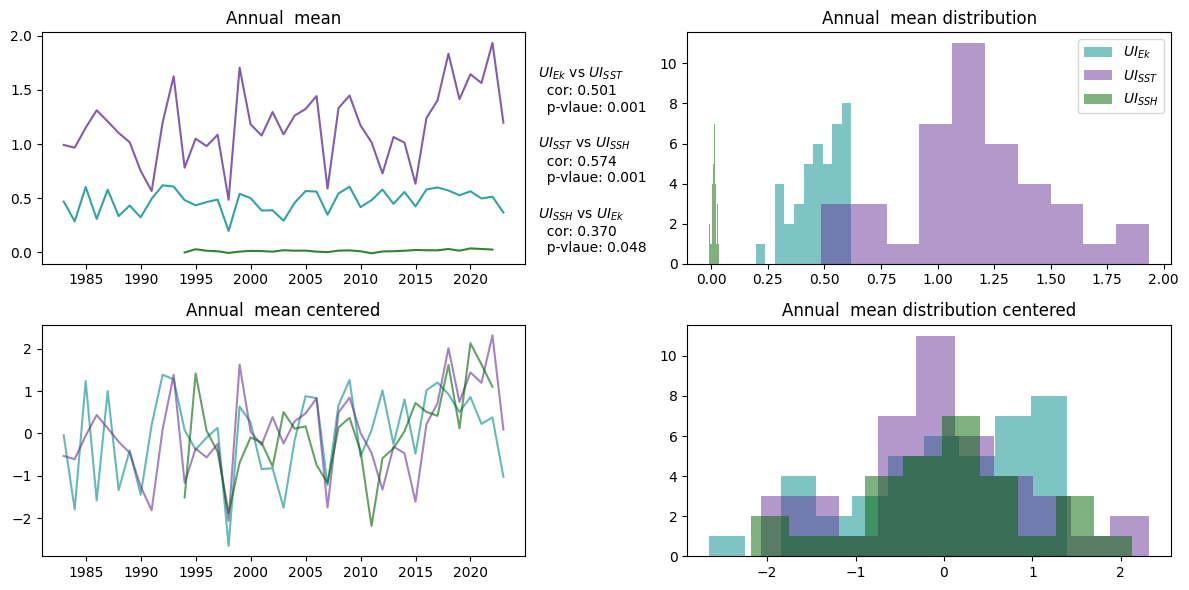

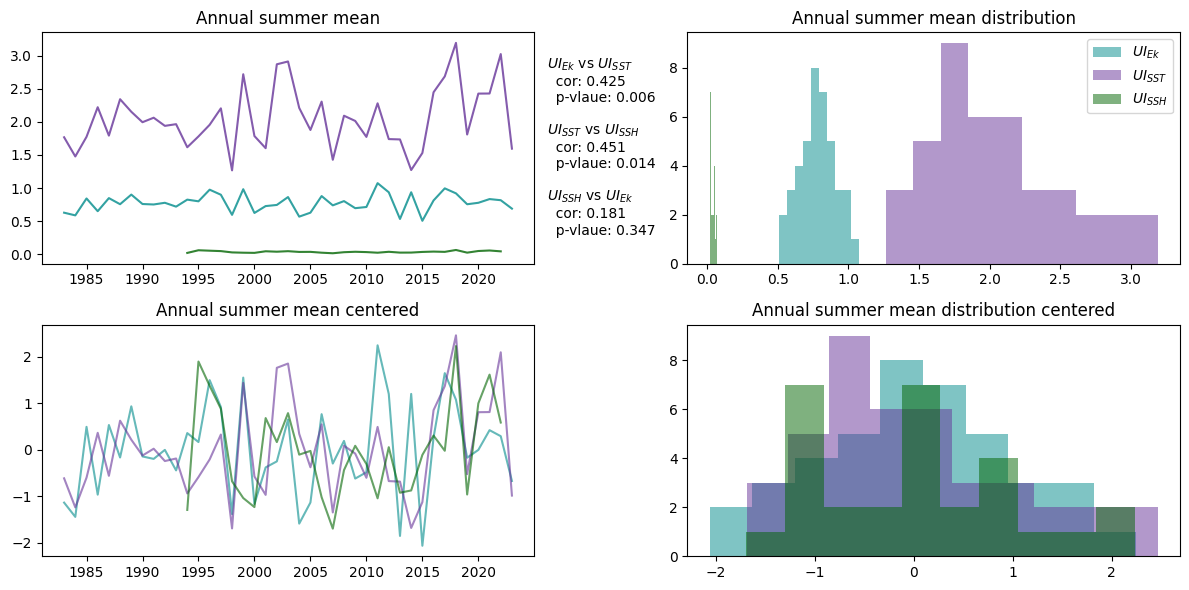

In [16]:
# onle the tree 'original' UIs
plot_correlation(Ek_annual, SST_annual, SSH_annual, summer = False, save = True, save_fig_as = 'Corr_annual_mean_whole_period')
plot_correlation(Ek_summer_annual, SST_summer_annual, SSH_summer_annual, summer = True, save = True, save_fig_as = 'Corr_season_summer_mean')

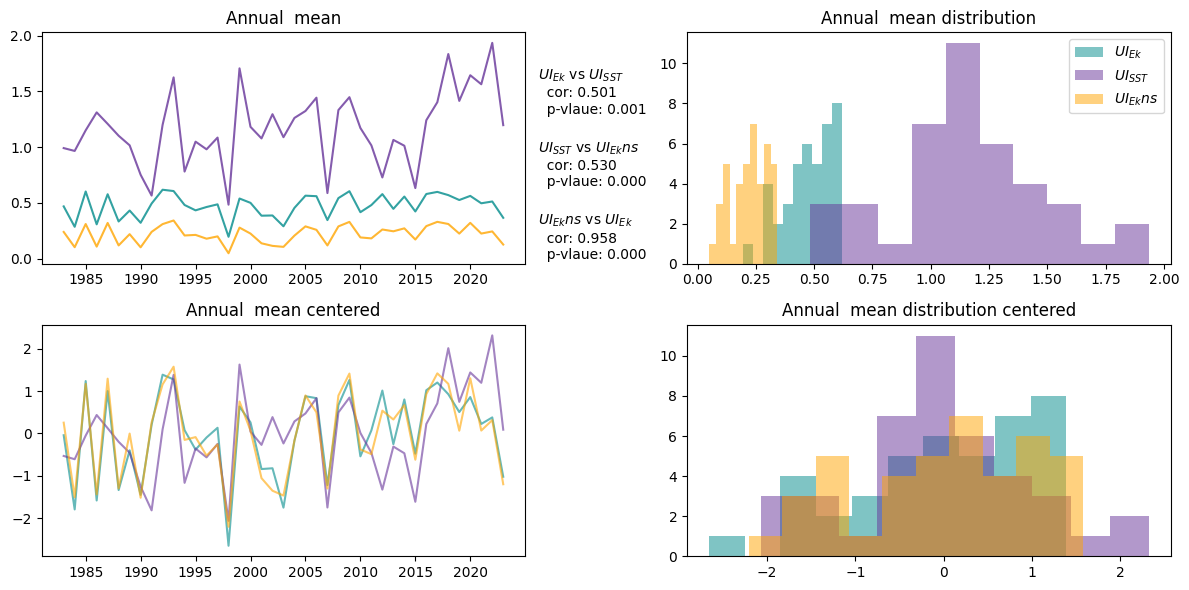

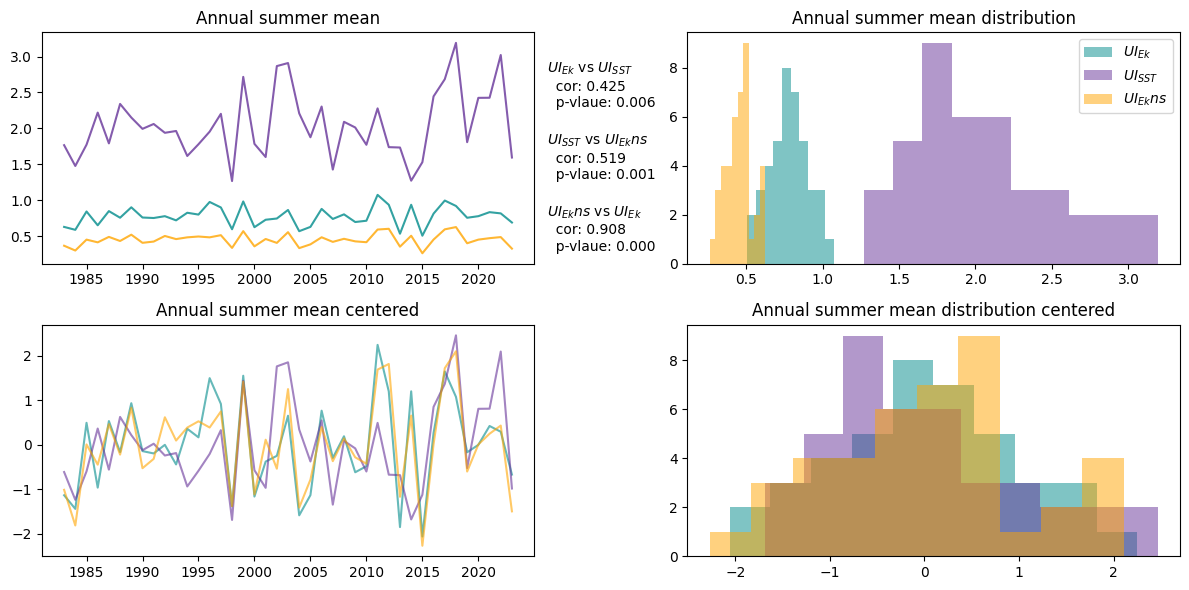

In [17]:
# SST and two UI Eks
plot_correlation_SST(Ek_annual, SST_annual, Ek_ns_annual, summer = False, save = True, save_fig_as = 'Corr_annual_mean_whole_period')
plot_correlation_SST(Ek_summer_annual, SST_summer_annual, Ek_ns_summer_annual, summer = True, save = True, save_fig_as = 'Corr_season_summer_mean_1')

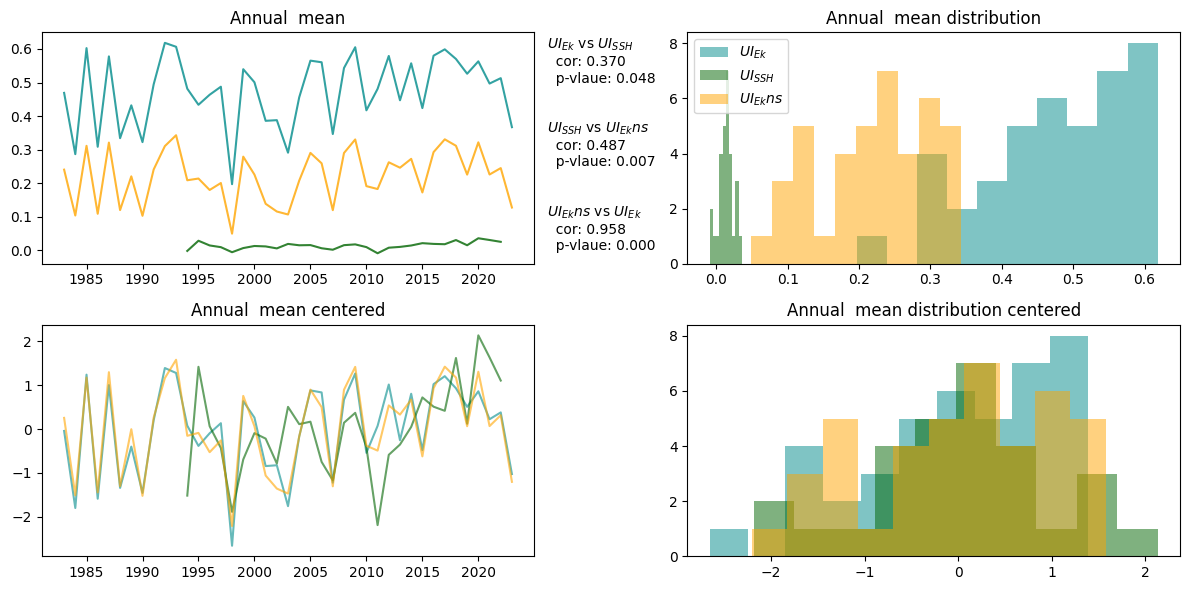

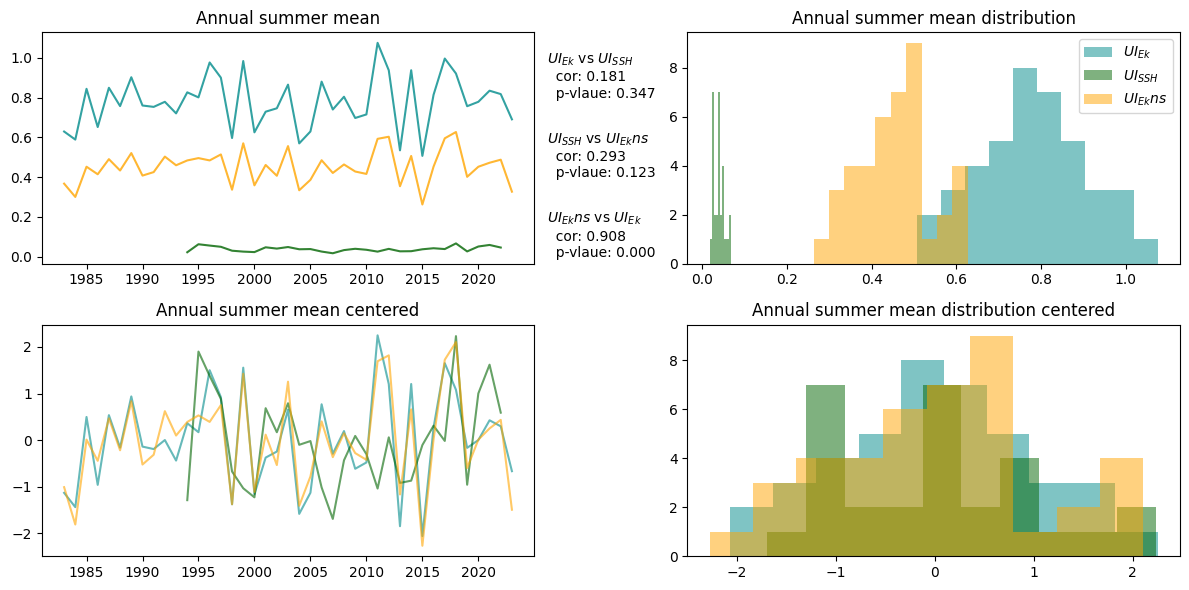

In [18]:
# SSH and two UI Eks
plot_correlation_SSH(Ek_annual, SSH_annual, Ek_ns_annual, summer = False, save = True, save_fig_as = 'Corr_annual_mean_whole_period')
plot_correlation_SSH(Ek_summer_annual, SSH_summer_annual, Ek_ns_summer_annual, summer = True, save = True, save_fig_as = 'Corr_season_summer_mean_2')

## With delay and different lats

In [19]:
# test what happens to the correlation coefficient we look at a delayed respones of SST to Ek
corr = np.zeros([3, 53])
for i in np.arange(0,53):
    # first select the time slice where UI Ek and UI SST overlap (time = slice(..., ...)) my UI_Ek starts a little earlier and is a little longer adjust time to match
    # then with every run of the loop add a week delay to the time window in UI SST 
    corr[0, i] = pearsonr(Ek.UI_mean.isel(time = slice(0, -53)), SST.UI_mean.isel(time = slice(0 + i, -53 + i)))[0] # UI_Ek, UI_SST
    corr[1, i] = pearsonr(Ek.UI_mean.isel(time = slice(0, len(SSH.time)-53)), SSH.UI_mean.isel(time = slice(0 + i, -53 + i)))[0] # UI_Ek, UI_SSH
    corr[2, i] = pearsonr(SST.UI_mean.isel(time = slice(0, len(SSH.time)-53)), SSH.UI_mean.isel(time = slice(0 + i, -53 + i)))[0] # UI_SST, UI_SSH
    #if i < 10:
    #    print(f'Correlation with {i} week delay: {corr[i]}')

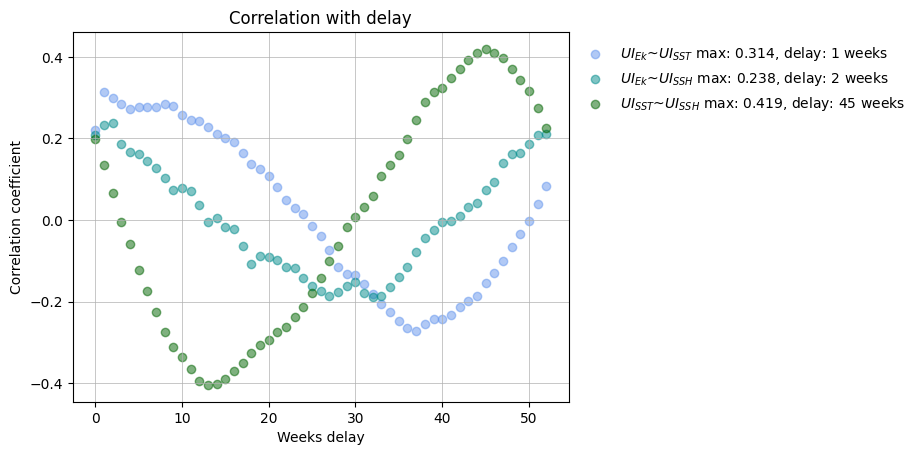

In [20]:
# plot the correlation 
plt.scatter(np.arange(0,53), corr[0,:], color = 'cornflowerblue', alpha = 0.5, 
            label = '$UI_{Ek}$~$UI_{SST}$' f' max: {corr[0,:].max():.3f}, delay: {np.where(corr[0,:] ==  corr[0,:].max())[0][0]} weeks');
plt.scatter(np.arange(0,53), corr[1,:], color = 'darkcyan', alpha = 0.5, 
            label = '$UI_{Ek}$~$UI_{SSH}$' f' max: {corr[1,:].max():.3f}, delay: {np.where(corr[1,:] ==  corr[1,:].max())[0][0]} weeks');
plt.scatter(np.arange(0,53), corr[2,:], color = 'darkgreen', alpha = 0.5, 
            label = '$UI_{SST}$~$UI_{SSH}$' f' max: {corr[2,:].max():.3f}, delay: {np.where(corr[2,:] ==  corr[2,:].max())[0][0]} weeks');

plt.title('Correlation with delay')
#plt.text(31, 0.14, f'Max correlation: {corr[0,:].max():.4f} \nwith delay: {np.where(corr[0,:] ==  corr[0,:].max())[0][0]} weeks')
plt.xlabel('Weeks delay')
plt.ylabel('Correlation coefficient')
plt.legend(bbox_to_anchor=(1.0, 1), loc = 'upper left', edgecolor = 'none', facecolor = 'none')
plt.grid(linewidth = 0.5)

plt.savefig('Corr_delay.png', dpi = 300, bbox_inches = 'tight')

In [21]:
# test what happens to the correlation coefficient we look at a delayed respones of SST to Ek
corr = np.zeros([4, 12])
for i in np.arange(0,12):
    # first select the time slice where UI Ek and UI SST overlap (time = slice(..., ...)) my UI_Ek starts a little earlier and is a little longer adjust time to match
    # then with every run of the loop add a week delay to the time window in UI SST 
    corr[0, i] = pearsonr(Ek.UI_mean.where((Ek.week_of_year >= 22-i) & (Ek.week_of_year <= 39-i), drop = True), SST.UI_mean.where((SST.week_of_year >= 22) & (SST.week_of_year <= 39), drop = True))[0] # UI_Ek, UI_SST
    corr[1, i] = pearsonr(Ek_ns.UI_mean.where((Ek_ns.week_of_year >= 22-i) & (Ek_ns.week_of_year <= 39-i), drop = True), SST.UI_mean.where((SST.week_of_year >= 22) & (SST.week_of_year <= 39), drop = True))[0] # UI_Ek, UI_SSH
    corr[2, i] = pearsonr(Ek.UI_mean.where(Ek.time == SSH.time).where((Ek.week_of_year >= 22-i) & (Ek.week_of_year <= 39-i), drop = True), SSH.UI_mean.where((SSH.week_of_year >= 22) & (SSH.week_of_year <= 39), drop = True))[0] # UI_Ek, UI_SSH
    corr[3, i] = pearsonr(Ek_ns.UI_mean.where(Ek_ns.time == SSH.time).where((Ek_ns.week_of_year >= 22-i) & (Ek_ns.week_of_year <= 39-i), drop = True), SSH.UI_mean.where((SSH.week_of_year >= 22) & (SSH.week_of_year <= 39), drop = True))[0] # UI_Ek, UI_SSH
        #if i < 10:
    #    print(f'Correlation with {i} week delay: {corr[i]}')

In [22]:
# correlation events in summer with 30 day delay (without 'rolling over years')
corr_summer_mean = np.full((12,4), np.nan)
year_arr = year_arr = np.full((41, 4), np.nan)

for advance in np.arange(0, 12):
    i = 0
    for year in np.unique(SST.time.dt.year.values):
    
        SST_sub = SST.UI_mean.where((SST.week_of_year >= 22) & (SST.week_of_year <= 39), drop = True).where(SST.time['time.year'] == year, drop = True)
        Ek_sub = Ek.UI_mean.where((Ek.week_of_year >= 22 - advance) & (Ek.week_of_year <= 39 - advance), drop = True).where(Ek.time['time.year'] == year, drop = True)
        Ek_ns_sub = Ek_ns.UI_mean.where((Ek_ns.week_of_year >= 22 - advance) & (Ek_ns.week_of_year <= 39 - advance), drop = True).where(Ek_ns.time['time.year'] == year, drop = True)
    
        # calculate correlation coefficients
        cor_Ek_SST= pearsonr(Ek_sub, SST_sub)
        cor_Ekns_SST = pearsonr(Ek_ns_sub, SST_sub)

        # only save correlation coefficient (instead of whole matrix)
        year_arr[i, 0] = cor_Ek_SST[0]     # i = year and 0 is the column ... i.e. once the column is full I take the mean over the whole year below
        year_arr[i, 1] = cor_Ekns_SST[0]
        i = i + 1
        
    corr_summer_mean[advance, 0] = year_arr[:, 0].mean()  # take the mean over the year and assign it to array, rows are delyas, column are correlation coeffs between the different combinations
    corr_summer_mean[advance, 1] = year_arr[:, 1].mean()
    
for advance in np.arange(0, 12):
    i = 0
    for year in np.unique(SSH.time.dt.year.values):
        SSH_sub = SSH.UI_mean.where((SSH.week_of_year >= 22) & (SSH.week_of_year <= 39), drop = True).where(SSH.time['time.year'] == year, drop = True) 
        Ek_sub = Ek.UI_mean.where((Ek.week_of_year >= 22 - advance) & (Ek.week_of_year <= 39 - advance), drop = True).where(Ek.time['time.year'] == year, drop = True)
        Ek_ns_sub = Ek_ns.UI_mean.where((Ek_ns.week_of_year >= 22 - advance) & (Ek_ns.week_of_year <= 39 - advance), drop = True).where(Ek_ns.time['time.year'] == year, drop = True)
        # correlation coefficients
        cor_Ek_SSH = pearsonr(Ek_sub, SSH_sub)
        cor_Ekns_SSH = pearsonr(Ek_ns_sub, SSH_sub)
        # save into matrix
        year_arr[i, 2] = cor_Ek_SSH[0]
        year_arr[i, 3] = cor_Ekns_SSH[0]
        i = i + 1

    corr_summer_mean[advance, 2] = np.nanmean(year_arr[:, 2])
    corr_summer_mean[advance, 3] = np.nanmean(year_arr[:, 3])

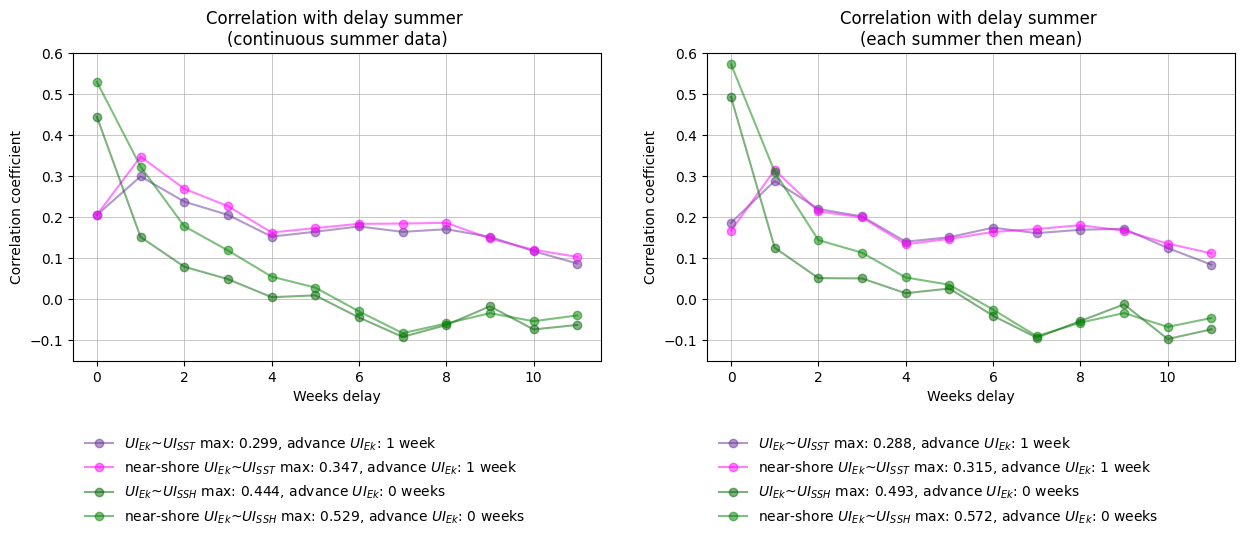

In [23]:
# plot the correlation 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 4))

ax1.plot(np.arange(0,12), corr[0,:], color = 'rebeccapurple', alpha = 0.5, marker = 'o', 
            label = '$UI_{Ek}$~$UI_{SST}$' f' max: {corr[0,:].max():.3f},' r' advance $UI_{Ek}$: ' f'{np.where(corr[0,:] ==  corr[0,:].max())[0][0]} week');
ax1.plot(np.arange(0,12), corr[1,:], color = 'magenta', alpha = 0.5, marker = 'o', 
            label = 'near-shore $UI_{Ek}$~$UI_{SST}$' f' max: {corr[1,:].max():.3f},' r' advance $UI_{Ek}$: ' f'{np.where(corr[1,:] ==  corr[1,:].max())[0][0]} week');
ax1.plot(np.arange(0,12), corr[2,:], color = 'darkgreen', alpha = 0.5, marker = 'o', 
            label = '$UI_{Ek}$~$UI_{SSH}$' f' max: {corr[2,:].max():.3f},' r' advance $UI_{Ek}$: ' f'{np.where(corr[2,:] ==  corr[2,:].max())[0][0]} weeks');
ax1.plot(np.arange(0,12), corr[3,:], color = 'green', alpha = 0.5, marker = 'o', 
            label = 'near-shore $UI_{Ek}$~$UI_{SSH}$' f' max: {corr[3,:].max():.3f},' r' advance $UI_{Ek}$: ' f'{np.where(corr[2,:] ==  corr[2,:].max())[0][0]} weeks');

ax1.set_title('Correlation with delay summer \n(continuous summer data)')
ax1.set_xlabel('Weeks delay')
ax1.set_ylabel('Correlation coefficient')
ax1.set_ylim(-0.15, 0.6)
ax1.legend(bbox_to_anchor=(0, -0.2), loc = 'upper left', edgecolor = 'none', facecolor = 'none')
ax1.grid(linewidth = 0.5)


ax2.plot(np.arange(0,12), corr_summer_mean[:,0], color = 'rebeccapurple', alpha = 0.5, marker = 'o', 
            label = '$UI_{Ek}$~$UI_{SST}$' f' max: {corr_summer_mean[:,0].max():.3f},' r' advance $UI_{Ek}$: ' f'{np.where(corr_summer_mean[:,0] ==  corr_summer_mean[:,0].max())[0][0]} week');
ax2.plot(np.arange(0,12), corr_summer_mean[:,1], color = 'magenta', alpha = 0.5, marker = 'o', 
            label = 'near-shore $UI_{Ek}$~$UI_{SST}$' f' max: {corr_summer_mean[:,1].max():.3f},' r' advance $UI_{Ek}$: ' f'{np.where(corr_summer_mean[:,1] ==  corr_summer_mean[:,1].max())[0][0]} week');
ax2.plot(np.arange(0,12), corr_summer_mean[:,2], color = 'darkgreen', alpha = 0.5, marker = 'o', 
            label = '$UI_{Ek}$~$UI_{SSH}$' f' max: {corr_summer_mean[:,2].max():.3f},' r' advance $UI_{Ek}$: ' f'{np.where(corr_summer_mean[:,2] ==  corr_summer_mean[:,2].max())[0][0]} weeks');
ax2.plot(np.arange(0,12), corr_summer_mean[:,3], color = 'green', alpha = 0.5, marker = 'o', 
            label = 'near-shore $UI_{Ek}$~$UI_{SSH}$' f' max: {corr_summer_mean[:,3].max():.3f},' r' advance $UI_{Ek}$: ' f'{np.where(corr_summer_mean[:,3] ==  corr_summer_mean[:,3].max())[0][0]} weeks');

ax2.set_title('Correlation with delay summer \n(each summer then mean)')
ax2.set_xlabel('Weeks delay')
ax2.set_ylabel('Correlation coefficient')
ax2.set_ylim(-0.15, 0.6)
ax2.legend(bbox_to_anchor=(0, -0.2), loc = 'upper left', edgecolor = 'none', facecolor = 'none')
ax2.grid(linewidth = 0.5)

#plt.savefig('Corr_delay.png', dpi = 300, bbox_inches = 'tight')

# in ax1 (on the left)
# the Ekman transport is advanced by x weeks compared to the summer period... but I think at the end it sort of rolls over so that should probably be a lower correlation becuase 
# it goes from start to end of summer
# what if I did summer mean correlation. i.e. calculate the correlation per summer and then take the mean? 

### From Explore_UIs.ipynb

In [24]:
# correlation events in summer with 30 day delay (without 'rolling over years')
corr_summer_week_delay = np.zeros([5,41])

for delay in np.arange(0, 5):
    i = 0
    for year in np.unique(SST.time.dt.year.values):
    
        SST_cor = SST.UI_mean.where((SST.week_of_year >= 22 + delay) & (SST.week_of_year <= 39 + delay), drop = True).where(SST.time['time.year'] == year, drop = True)
        Ek_cor = Ek.UI_mean.where((SST.week_of_year >= 22) & (SST.week_of_year <= 39), drop = True).where(SST.time['time.year'] == year, drop = True)
    
        # calculate correlation coefficients
        cor = pearsonr(SST_cor, Ek_cor)
        # only save correlation coefficient (instead of whole matrix)
        corr_summer_week_delay[delay, i] = cor[0]
    
        i = i + 1

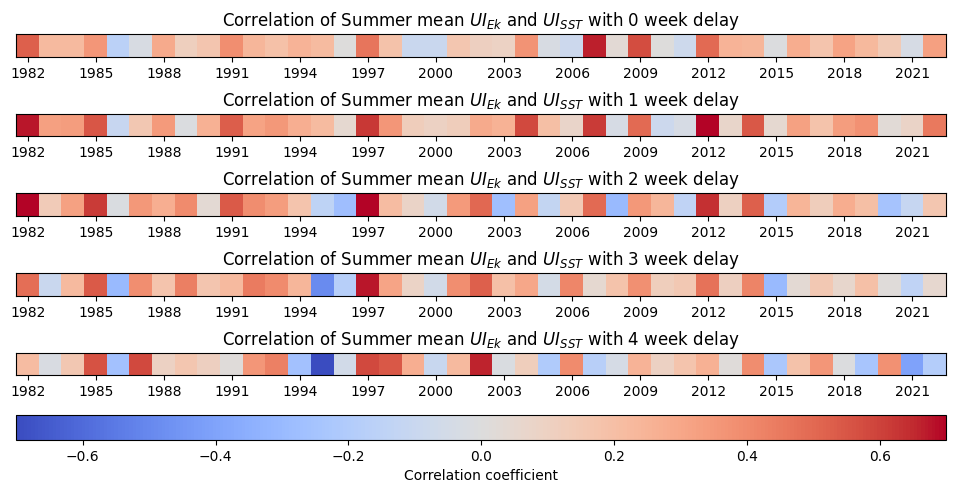

In [25]:
fig, axs = plt.subplots(5, 1, figsize = (12, 5))

for delay in np.arange(0, 5):
    ax = axs[delay]
    
    plot = ax.imshow(corr_summer_week_delay[delay:delay+1, :], cmap = 'coolwarm', vmin = -0.7, vmax = 0.7)
    ax.set_yticks([])
    ax.set_xticks(ticks = np.arange(0,42,3), labels = np.arange(1982, 2022, 3))
    ax.set_title(r'Correlation of Summer mean $UI_{Ek}$ and $UI_{SST}$' f' with {delay} week delay')

# add colorbar
cbar_ax = fig.add_axes([0.125, 0.025, 0.775, 0.05])
fig.colorbar(plot, cax=cbar_ax, label = 'Correlation coefficient', orientation = 'horizontal')

#fig.savefig('../Iberian_Coast_Upwelling/Figures/UI_Summer_Ek_delays_Correlation_mean.png', dpi = 300, bbox_inches='tight')

# delaying the SST by one week gives a better correlation with the most positive values compared to the others 

In [26]:
## same as above but for 3 different latitudes 41, 39 37

corr_summer_1_week_delay_lats = np.zeros([3,41])
lats = [41, 39, 37]

for n in [0, 1, 2]:
    i = 0
    for year in np.unique(SST.time.dt.year.values):
    
        SST_cor = SST.UI.sel(lat = lats[n], lon = -15, method = 'nearest').where((SST.week_of_year >= 22) & (SST.week_of_year <= 39), drop = True).where(SST.time['time.year'] == year, drop = True)
        Ek_cor = Ek.UI.sel(lat = lats[n], lon = -10, method = 'nearest').where((SST.week_of_year >= 21) & (SST.week_of_year <= 38), drop = True).where(SST.time['time.year'] == year, drop = True)
    
        # calculate correlation coefficients
        cor = pearsonr(SST_cor, Ek_cor)
        # only save correlation coefficient (instead of whole matrix)
        corr_summer_1_week_delay_lats[n,i] = cor[0]
    
        i = i + 1

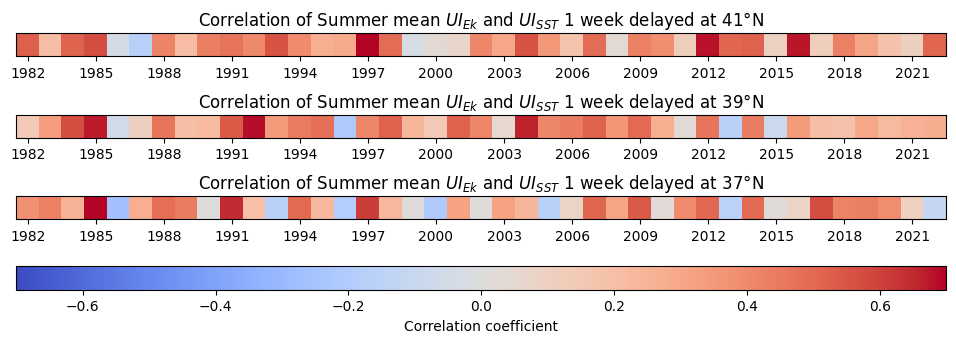

In [27]:
fig, axs = plt.subplots(3, 1, figsize = (12, 3))

for n in np.arange(0, 3):
    ax = axs[n]
    
    plot = ax.imshow(corr_summer_1_week_delay_lats[n:n+1, :], cmap = 'coolwarm', vmin = -0.7, vmax = 0.7)
    ax.set_yticks([])
    ax.set_xticks(ticks = np.arange(0,42,3), labels = np.arange(1982, 2022, 3))
    ax.set_title(r'Correlation of Summer mean $UI_{Ek}$ and $UI_{SST}$' f' 1 week delayed at {lats[n]}°N')

# add colorbar
cbar_ax = fig.add_axes([0.125, -0.05, 0.775, 0.08])
fig.colorbar(plot, cax=cbar_ax, label = 'Correlation coefficient', orientation = 'horizontal')

#fig.savefig(f'../Iberian_Coast_Upwelling/Figures/UI_Summer_Ek_1_week_delay_Correlation_lats.png', dpi = 300, bbox_inches='tight')

## the latitude makes a differnece when looking at correlationn -> seems to be overall better correlated

In [28]:
## it makes sense that correlation is better on local scales... the details get lost on the larger scale ... 

## Plot correlation per summer season across all lats (0.25° res)

### UI<sub>Ek</sub> vs UI<sub>SST</sub> with 1 week delay

In [38]:
## same as above but for all lats (UI_SST resampled to UI_Ek 0.25° res)
# sel lat slice where I acutally calculate the UI_SST, sel same area for UI_Ek (to avoid complications with nans
# the limits are dependent on the min and max in the SST_UI -> where the mid-shelf line ends N and S extent
Ek_res = Ek.UI.where(Ek.lon == -10.5).sel(lat = slice(37, 43.5))
Ek_ns_res = Ek_ns.UI.sel(lat = slice(37, 43.5))
SST_res = SST.UI.interp(lat = Ek_res.lat.values, method = 'linear').sel(lat = slice(37.25, 43.25)) # move one lat in -> to avoid nans at edges

In [30]:
# calculate the correlation
corr_summer_1_week_delay_all_lats = np.zeros([25,41]) #25 lats and len years is also 41
lats = SST_res.lat.values

for n in np.arange(len(SST_res.lat.values)):
    i = 0
    for year in np.unique(SST.time.dt.year.values):

        # keep 1 week delay as it has the highest correlation -> go through every lat at every time step to get a
        # summer correlation for every year at 0.25° lat resolution
        SST_cor = SST_res.sel(lat = lats[n], lon = -15, method = 'nearest').where((SST.week_of_year >= 22) & (SST.week_of_year <= 39), drop = True).where(SST.time['time.year'] == year, drop = True)
        Ek_cor = Ek_res.sel(lat = lats[n], lon = -10.5).where((SST.week_of_year >= 21) & (SST.week_of_year <= 38), drop = True).where(SST.time['time.year'] == year, drop = True)
    
        # calculate correlation coefficients
        cor = pearsonr(SST_cor, Ek_cor)
        # only save correlation coefficient (instead of whole matrix)
        corr_summer_1_week_delay_all_lats[n,i] = cor[0]
    
        i = i + 1

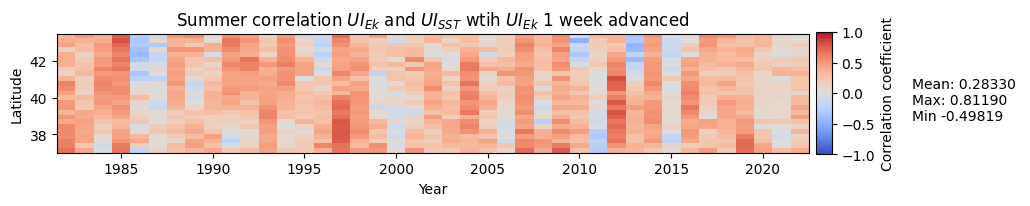

In [33]:
plt.figure(figsize = (10,6))
# x and y for the axis
x = Ek_ns_res.time.dt.isocalendar().year.values
y = Ek_ns_res.lat.values

plt.imshow(corr_summer_1_week_delay_all_lats[0:25,:], cmap = 'coolwarm', vmin = -1, vmax = 1,
          extent = [min(x-0.5), max(x+0.5), min(y), max(y)]) #set x and y axis
plt.colorbar(label = 'Correlation coefficient', fraction = 0.02, aspect = 7.9, pad = 0.01)
plt.title(r'Summer correlation $UI_{Ek}$ and $UI_{SST}$ wtih $UI_{Ek}$ 1 week advanced')
plt.xlabel('Year')
plt.ylabel('Latitude');

mean = corr_summer_1_week_delay_all_lats[0:25,:].mean()
maximum = corr_summer_1_week_delay_all_lats[0:25,:].max()
minimum = corr_summer_1_week_delay_all_lats[0:25,:].min()
plt.figtext(0.98, 0.45, f'Mean: {mean:.5f} \nMax: {maximum:.5f} \nMin {minimum:.5f}')

plt.savefig('Corr_UI_Ek_and_UI_SST.png', dpi = 300, bbox_inches = 'tight')
# there are really no lats where we see consistently high or low correlation, it is much more dependent on the year

In [34]:
abs(corr_summer_1_week_delay_all_lats).mean()

0.31262566158114524

In [39]:
# calculate the correlation but for near-shore UI Ek
corr_summer_1_week_delay_all_lats_Ekns = np.zeros([25,41]) #25 lats and len years is also 41
lats = SST_res.lat.values

for n in np.arange(len(SST_res.lat.values)):
    i = 0
    for year in np.unique(SST.time.dt.year.values):

        # keep 1 week delay as it has the highest correlation -> go through every lat at every time step to get a
        # summer correlation for every year at 0.25° lat resolution
        SST_cor = SST_res.sel(lat = lats[n], lon = -15, method = 'nearest').where((SST.week_of_year >= 22) & (SST.week_of_year <= 39), drop = True).where(SST.time['time.year'] == year, drop = True)
        Ek_ns_cor = Ek_ns_res.sel(lat = lats[n]).mean(dim = 'lon').where((SST.week_of_year >= 21) & (SST.week_of_year <= 38), drop = True).where(SST.time['time.year'] == year, drop = True)
    
        # calculate correlation coefficients
        cor = pearsonr(SST_cor, Ek_ns_cor)
        # only save correlation coefficient (instead of whole matrix)
        corr_summer_1_week_delay_all_lats_Ekns[n,i] = cor[0]
    
        i = i + 1

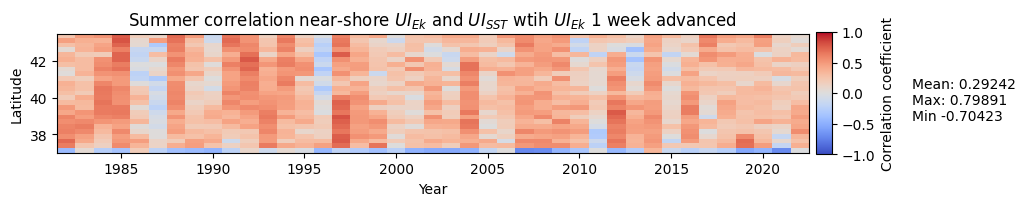

In [40]:
plt.figure(figsize = (10,6))
# x and y for the axis
x = Ek_res.time.dt.isocalendar().year.values
y = Ek_res.lat.values

plt.imshow(corr_summer_1_week_delay_all_lats_Ekns[0:25,:], cmap = 'coolwarm', vmin = -1, vmax = 1,
          extent = [min(x-0.5), max(x+0.5), min(y), max(y)]) #set x and y axis
plt.colorbar(label = 'Correlation coefficient', fraction = 0.02, aspect = 7.9, pad = 0.01)
plt.title(r'Summer correlation near-shore $UI_{Ek}$ and $UI_{SST}$ wtih $UI_{Ek}$ 1 week advanced')
plt.xlabel('Year')
plt.ylabel('Latitude');

mean = corr_summer_1_week_delay_all_lats_Ekns[0:25,:].mean()
maximum = corr_summer_1_week_delay_all_lats_Ekns[0:25,:].max()
minimum = corr_summer_1_week_delay_all_lats_Ekns[0:25,:].min()
plt.figtext(0.98, 0.45, f'Mean: {mean:.5f} \nMax: {maximum:.5f} \nMin {minimum:.5f}')

plt.savefig('Corr_UI_Ek_and_UI_SST.png', dpi = 300, bbox_inches = 'tight')
# there are really no lats where we see consistently high or low correlation, it is much more dependent on the year (except for ~37°
# it really is not that different to what I have above.. except for the bottom rows

In [41]:
abs(corr_summer_1_week_delay_all_lats_Ekns).mean() # overall slightly higher than above

0.33608924431732246

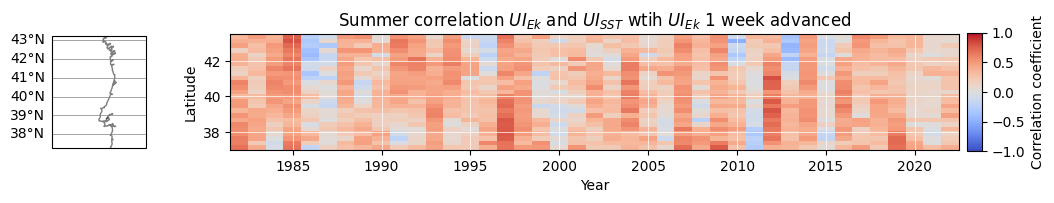

In [42]:
# with map for orientation... 
fig = plt.figure(figsize = (12,4))
gs = fig.add_gridspec(1,2,width_ratios=[1,8])
ax1 = fig.add_subplot(gs[0], projection = ccrs.PlateCarree())
ax2 = fig.add_subplot(gs[1])

# Portugal map
ax1.set_extent([-12, -7, 43.25, 37.25])
ax1.coastlines(color = 'black', alpha = 0.5)
gls = ax1.gridlines(draw_labels=False, linewidth = 0.5, color = 'grey')
gls.xlines = False
gls.left_labels = True
ax1.set_title(' ')

# x and y for the axis
x = Ek_res.time.dt.isocalendar().year.values
y = Ek_res.lat.values

im = ax2.imshow(corr_summer_1_week_delay_all_lats[0:25,:], cmap = 'coolwarm', vmin = -1, vmax = 1,
          extent = [min(x-0.5), max(x+0.5), min(y), max(y)]) #set x and y axis
plt.colorbar(im, label = 'Correlation coefficient', fraction = 0.02, aspect = 7.9, pad = 0.01)
ax2.set_title(r'Summer correlation $UI_{Ek}$ and $UI_{SST}$ wtih $UI_{Ek}$ 1 week advanced')
ax2.set_xlabel('Year')
ax2.set_ylabel('Latitude');
plt.grid(im, color = 'white', lw = 0.5)

### UI<sub>Ek</sub> vs UI<sub>SSH</sub> with 4 week delay
calculate spatial and temp correlation for  UI<sub>Ek</sub> vs UI<sub>SSH</sub> with 4 week delay (average best correlation)

In [ ]:
## same as above but for all lats (UI_SST resampled to UI_Ek 0.25° res)
# sel lat slice where I acutally calculate the UI_SST, sel same area for UI_Ek (to avoid complications with nans
# the limits are dependent on the min and max in the SST_UI -> where the mid-shelf line ends N and S extent
SSH_res = SSH.UI.interp(lat = Ek_res.lat.values, method = 'linear').sel(lat = slice(37.25, 43.25)) # move one lat in -> to avoid nans at edges
# SSH_res = SSH_res.sel(time = slice('01-01-1993', '31-12-2021')) # there is one wierd 1992 time variable (first week of ds) -> I do this when I load the data now
# sel same length of datset for Ek
Ek_res = Ek_res.sel(time = slice(SSH.time.min(), SSH.time.max()))

In [ ]:
# calculate the correlation
corr_summer_1_week_delay_all_lats = np.zeros([25,29]) #25 lats and len years is 29
lats = SST_res.lat.values

for n in np.arange(len(SST_res.lat.values)):
    i = 0
    for year in np.unique(SSH_res.time.dt.year.values):

        # keep 1 week delay as it has the highest correlation -> go through every lat at every time step to get a
        # summer correlation for every year at 0.25° lat resolution
        # summer is week 22 to 39 so I am advancing Ek by 4 weeks
        SSH_cor = SSH_res.sel(lat = lats[n], lon = -10.5, method = 'nearest').where((SSH.week_of_year >= 22) & (SSH.week_of_year <= 39), drop = True).where(SSH.time['time.year'] == year, drop = True)
        Ek_cor = Ek_res.sel(lat = lats[n], lon = -10.5).where((SST.week_of_year >= 18) & (SSH.week_of_year <= 35), drop = True).where(SSH.time['time.year'] == year, drop = True)
    
        # calculate correlation coefficients
        cor = pearsonr(Ek_cor, SSH_cor)
        # only save correlation coefficient (instead of whole matrix)
        corr_summer_1_week_delay_all_lats[n,i] = cor[0]
    
        i = i + 1

In [ ]:
plt.figure(figsize = (10,6))
# x and y for the axis
x = SSH_res.time.dt.isocalendar().year.values
y = SSH_res.lat.values

plt.imshow(corr_summer_1_week_delay_all_lats, cmap = 'coolwarm', vmin = -1, vmax = 1,
          extent = [min(x-0.5), max(x+0.5), max(y)]) #set x and y axis
plt.colorbar(label = 'Correlation coefficient', fraction = 0.02, aspect = 10.4, pad = 0.01)
plt.title(r'Summer correlation $UI_{Ek}$ and $UI_{SSH}$ wtih $UI_{Ek}$ 4 weeks advanced')
plt.xlabel('Year')
plt.ylabel('Latitude');

mean = corr_summer_1_week_delay_all_lats[0:25,:].mean()
maximum = corr_summer_1_week_delay_all_lats[0:25,:].max()
minimum = corr_summer_1_week_delay_all_lats[0:25,:].min()
plt.figtext(0.98, 0.45, f'Mean: {mean:.5f} \nMax: {maximum:.5f} \nMin {minimum:.5f}')

plt.savefig('Corr_UI_Ek_and_UI_SSH.png', dpi = 300, bbox_inches = 'tight')

# there are really no lats where we see consistently high or low correlation, it is much more dependent on the year
# why are the correlations over the year often so uniform... this irritates me

### UI<sub>SST</sub> vs UI<sub>SSH</sub> with no  delay
calculate spatial and temp correlation for  UI<sub>SST</sub> vs UI<sub>SSH</sub> 

In [ ]:
# sel same length of datset for SST_res
SST_res = SST_res.sel(time = slice(SSH.time.min(), SSH.time.max()))

In [ ]:
# calculate the correlation
corr_summer_1_week_delay_all_lats = np.zeros([25,29]) #25 lats and len years is 29
lats = SST_res.lat.values

for n in np.arange(len(SST_res.lat.values)):
    i = 0
    for year in np.unique(SSH_res.time.dt.year.values):

        # keep 1 week delay as it has the highest correlation -> go through every lat at every time step to get a
        # summer correlation for every year at 0.25° lat resolution
        # summer is week 22 to 39 so I am advancing Ek by 4 weeks
        SSH_cor = SSH_res.sel(lat = lats[n], lon = -10.5, method = 'nearest').where((SSH.week_of_year >= 22) & (SSH.week_of_year <= 39), drop = True).where(SSH.time['time.year'] == year, drop = True)
        SST_cor = SST_res.sel(lat = lats[n], lon = -15, method = 'nearest').where((SST.week_of_year >= 22) & (SSH.week_of_year <= 39), drop = True).where(SSH.time['time.year'] == year, drop = True)
    
        # calculate correlation coefficients
        cor = pearsonr(SST_cor, SSH_cor)
        # only save correlation coefficient (instead of whole matrix)
        corr_summer_1_week_delay_all_lats[n,i] = cor[0]
    
        i = i + 1

In [ ]:
plt.figure(figsize = (10,6))
# x and y for the axis
x = SSH_res.time.dt.isocalendar().year.values
y = SSH_res.lat.values

plt.imshow(corr_summer_1_week_delay_all_lats, cmap = 'coolwarm', vmin = -1, vmax = 1,
          extent = [min(x-0.5), max(x+0.5), min(y), max(y)]) #set x and y axis
plt.colorbar(label = 'Correlation coefficient', fraction = 0.02, aspect = 10.4, pad = 0.01)
plt.title(r'Summer correlation $UI_{SST}$ and $UI_{SSH}$ at same time')
plt.xlabel('Year')
plt.ylabel('Latitude');

mean = corr_summer_1_week_delay_all_lats[0:25,:].mean()
maximum = corr_summer_1_week_delay_all_lats[0:25,:].max()
minimum = corr_summer_1_week_delay_all_lats[0:25,:].min()
plt.figtext(0.98, 0.45, f'Mean: {mean:.5f} \nMax: {maximum:.5f} \nMin {minimum:.5f}')

plt.savefig('Corr_UI_SST_and_UI_SSH.png', dpi = 300, bbox_inches = 'tight')

# there are really no lats where we see consistently high or low correlation, it is much more dependent on the year
# why are the correlations over the year often so uniform... this irritates me

In [ ]:
# could summarise the code above into a function
# maybe the seasonal mean correlation just makes the most sense... 